In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import time
from copy import copy
import matplotlib.pyplot as plt

C:\Anaconda\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env_name='FrozenLake-v0'
env = gym.make(env_name)
env_size = env.observation_space.n
action_size = env.action_space.n
learning_rate=0.1
gamma=0.99
epsilon=0.1
num_episodes=5000
debug=True
debug_scale=500 # show output at every 500

In [27]:
tf.reset_default_graph()

# Feed-forward part of the network
# Again, declaring the model first before anything gets in.

# this is where the input layer, first layer, and Qout layer get declared
inputs1 = tf.placeholder(shape=[1,env_size], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([env_size, action_size], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout,1)

# Define loss function (sum of square difference between target and prediction Q values)
nextQ = tf.placeholder(shape=[1,action_size], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
updateModel = optimizer.minimize(loss)

init = tf.initialize_all_variables()

# Lists for total rewards and steps to get to final state in that episode
total_rewards = []
steps_to_complete = []
success_rates = []

# https://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/
# to avoid local minimum
# need to store s, a, r, s', and copy of env.
replay_memory = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        show_episode = (debug and i % debug_scale == 0)
        if show_episode:
            print("Showing epsiode {}/{} ...\n".format(i, num_episodes))
            #time.sleep(1)
            
        # reset environment for every episode.
        state = env.reset()
        cumulative_reward = 0
        done = False
        current_step = 0 # per each of 5000 episodes, we have steps
        # DQN
        while not done:
            if show_episode:
                env.render() #oh.. this is useful.
                time.sleep(0.1)

                current_step += 1
            

            # excluding first step 
            if current_step > 0:
                random_index = np.random.randint(0, len(replay_memory))
                # state and action[0] would be used for new rewards and new states I guess..
                # how to set the state again in the env?
                [state, action[0], reward, new_state] = replay_memory[random_index]
                
            
            # 1. Do a feedforward pass for the current state s to get predicted Q-values for all actions.
            # Predict next action using NN rather that querying Q-table
            # this is where the current state is. when reset, it would be [1, 0, 0, ...]
            one_hot_encoded_state = np.identity(env_size)[state:state+1]
            # Qout: the output layer with different values for each action
            # predict: declares that we would get the argmax action.
            action, q_values = sess.run([predict, Qout], feed_dict={inputs1:one_hot_encoded_state})

            # Epsilon greedy (bigger epsilon more random)
            # sample one number from 0 to 1.
            
            '''
            if np.random.rand(1) < epsilon:
                # Replace chosen action with random action
                action[0] = env.action_space.sample()
            
            '''
            
            
                
                
            # Take action (either chosen or random)
            new_state, reward, done, _ = env.step(action[0])
        
            # 2. Do a feedforward pass for the next state s′ and calculate maximum over all network outputs maxa′Q(s′,a′).
            # encode new state, 
            one_hot_encoded_new_state = np.identity(env_size)[new_state:new_state+1]
            Q1 = sess.run(Qout, feed_dict={inputs1:one_hot_encoded_new_state})
            maxQ1 = np.max(Q1)
            
            # 3. Set Q-value target for action a to r+γmaxa′Q(s′,a′) (use the max calculated in step 2).
            # For all other actions, set the Q-value target to the same as originally returned from step 1, 
            # making the error 0 for those outputs.

            targetQ = q_values
            targetQ[0,action[0]] = reward + gamma*maxQ1

            # Update the weights using backpropagation.
            # I don't think you do anything with _ that receives updated model and W1 that updates W??
            # but still the W does get updated.
            _,W1 = sess.run([updateModel,W], feed_dict={inputs1:one_hot_encoded_state, nextQ:targetQ})

            # log the current experience in replay_memory
            replay_memory.append([state, action[0], reward, new_state])
            
            # For logging
            cumulative_reward += reward
            # Move to next state
            state = new_state

            if done:
                epsilon = 1.0/((i/50) + 10)
                break

        steps_to_complete.append(current_step)
        total_rewards.append(cumulative_reward) # can only be 1 or 0 depending on success/failure
        success_rates.append(sum(total_rewards) / len(total_rewards))
        
        if show_episode:
            print("Completed with cumulative reward of {}...\n".format(cumulative_reward))
            #time.sleep(1)



Showing epsiode 0/5000 ...


SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
Completed with cumulative reward of 0.0...

Showing epsiode 500/5000 ...


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HF

  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
Completed with cumulative reward of 0.0...

Showing epsiode 3500/5000 ...


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
Completed with cumulative reward of 1.0...

Showing epsiode 4000/5000 ...


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (L

In [32]:
np.shape(steps_to_complete), sum(total_rewards) / len(total_rewards)

((5000,), 0.5684)

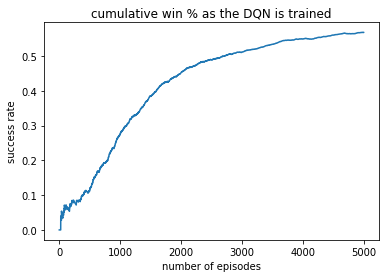

In [33]:
plt.plot(success_rates)
plt.xlabel("number of episodes")
plt.ylabel("success rate")
plt.title("cumulative win % as the DQN is trained")
plt.show()

In [31]:
for i in range(10):
    print(np.random.randint(0, 2))

0
0
0
1
0
0
0
0
0
0


In [37]:
a = 1
b = copy(a)
a = 2
print (a, b)

2 1
